<h1 align="center">Обучение моделей регрессии</h1>

<h2>Примечание по ноутбуку:</h2>
<h3>Внимание⚠️ — после проблем на последних этапах ноутбук был полностью переписан.</h3>

<h2>1. 📚 Импорт библиотек и настройка</h2>

In [4]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
# warnings.filterwarnings("ignore", category=UserWarning)

project_root = os.path.dirname(os.getcwd())
sys.path.append(project_root)

from src.data.loader import load_car_data
from src.features.preprocessing import preprocess_data

print("✅ Библиотеки загружены")

✅ Библиотеки загружены


<h2>2. 📁 Загрузка данных и предобработка</h2>

In [5]:
df = load_car_data()
print("✅ car_data.csv загружен")

X_train, X_test, y_train, y_test = preprocess_data(df, 'price')
print("✅ X_train, X_test, y_test, y_train готовы: ")

print("📊 Размеры данных:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}") 
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

✅ car_data.csv загружен
✅ X_train, X_test, y_test, y_train готовы: 
📊 Размеры данных:
X_train: (164, 55)
X_test: (41, 55)
y_train: (164,)
y_test: (41,)


<h2>3. 🤖 Обучение моделей регрессии</h2>

In [6]:
results = {}
models = {}
predictions = {}

<h3>3.1 Linear Regression/Ridge Regression</h3>

In [7]:
print("\n" + "="*50)
print("1. Обучаем Linear Regression...")
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

models['Linear Regression'] = lin_reg
predictions['Linear Regression'] = y_pred_lin

# 2. Ridge Regression с RandomizedSearchCV
print("\n" + "="*50)
print("2. Настраиваем Ridge Regression...")
ridge = Ridge()
ridge_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr']
}

ridge_search = RandomizedSearchCV(
    ridge, ridge_params, n_iter=20, cv=5, 
    scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1
)
ridge_search.fit(X_train, y_train)

print(f"   Лучшие параметры: {ridge_search.best_params_}")
models['Ridge'] = ridge_search.best_estimator_
predictions['Ridge'] = ridge_search.predict(X_test)


1. Обучаем Linear Regression...

2. Настраиваем Ridge Regression...
   Лучшие параметры: {'solver': 'svd', 'alpha': 0.1}


<h3>3.3 Random Forest Regressor</h3>

In [8]:
# 3. Random Forest с RandomizedSearchCV
print("\n" + "="*50)
print("3. Настраиваем Random Forest...")
rf = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']
}

rf_search = RandomizedSearchCV(
    rf, rf_params, n_iter=20, cv=5,
    scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1
)
rf_search.fit(X_train, y_train)

print(f"   Лучшие параметры: {rf_search.best_params_}")
models['Random Forest'] = rf_search.best_estimator_
predictions['Random Forest'] = rf_search.predict(X_test)


3. Настраиваем Random Forest...
   Лучшие параметры: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}


<h3>3.4 Gradient Boosting (XGBoost)</h3>

In [9]:
print("\n" + "="*50)
print("4. Настраиваем XGBoost...")
xgb = XGBRegressor(random_state=42, n_jobs=-1)
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_search = RandomizedSearchCV(
    xgb, xgb_params, n_iter=25, cv=5,
    scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1
)
xgb_search.fit(X_train, y_train)

print(f"   Лучшие параметры: {xgb_search.best_params_}")
models['XGBoost'] = xgb_search.best_estimator_
predictions['XGBoost'] = xgb_search.predict(X_test)


4. Настраиваем XGBoost...
   Лучшие параметры: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


<h2>4. 📊 Анализ результатов</h2>

In [10]:
print("\n" + "="*50)
print("📊 РАСЧЕТ МЕТРИК ДЛЯ ВСЕХ МОДЕЛЕЙ")
print("="*50)

for name, y_pred in predictions.items():
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    median_ae = np.median(np.abs(y_test - y_pred))
    
    accuracy_10pct = np.mean(np.abs((y_test - y_pred) / y_test) < 0.1) * 100
    
    results[name] = {
        'MSE': mse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape,
        'Median AE': median_ae,
        'Accuracy <10% (%)': accuracy_10pct
    }
    
    print(f"\n{name}:")
    print(f"  MSE: {mse:,.0f}")
    print(f"  MAE: {mae:,.0f}")
    print(f"  R²: {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  Median AE: {median_ae:,.0f}")
    print(f"  Accuracy <10%: {accuracy_10pct:.2f}%")


📊 РАСЧЕТ МЕТРИК ДЛЯ ВСЕХ МОДЕЛЕЙ

Linear Regression:
  MSE: 8,820,174
  MAE: 2,052
  R²: 0.8737
  MAPE: 15.52%
  Median AE: 1,226
  Accuracy <10%: 46.34%

Ridge:
  MSE: 7,297,923
  MAE: 1,912
  R²: 0.8955
  MAPE: 14.24%
  Median AE: 1,502
  Accuracy <10%: 43.90%

Random Forest:
  MSE: 3,232,979
  MAE: 1,379
  R²: 0.9537
  MAPE: 10.69%
  Median AE: 1,233
  Accuracy <10%: 60.98%

XGBoost:
  MSE: 4,220,546
  MAE: 1,495
  R²: 0.9395
  MAPE: 11.02%
  Median AE: 954
  Accuracy <10%: 65.85%


In [11]:
results_df = pd.DataFrame(results).T
round_dict = {'MSE': 0, 'MAE': 0, 'R²': 4, 'MAPE (%)': 2, 'Median AE': 0, 'Accuracy <10% (%)': 2}

print('\n' + "📈 ОБЩИЕ РЕЗУЛЬТАТЫ:")
print("="*60)
print(results_df.round(round_dict))


📈 ОБЩИЕ РЕЗУЛЬТАТЫ:
                         MSE     MAE      R²  MAPE (%)  Median AE  \
Linear Regression  8820174.0  2052.0  0.8737     15.52     1226.0   
Ridge              7297923.0  1912.0  0.8955     14.24     1502.0   
Random Forest      3232979.0  1379.0  0.9537     10.69     1233.0   
XGBoost            4220546.0  1495.0  0.9395     11.02      954.0   

                   Accuracy <10% (%)  
Linear Regression              46.34  
Ridge                          43.90  
Random Forest                  60.98  
XGBoost                        65.85  


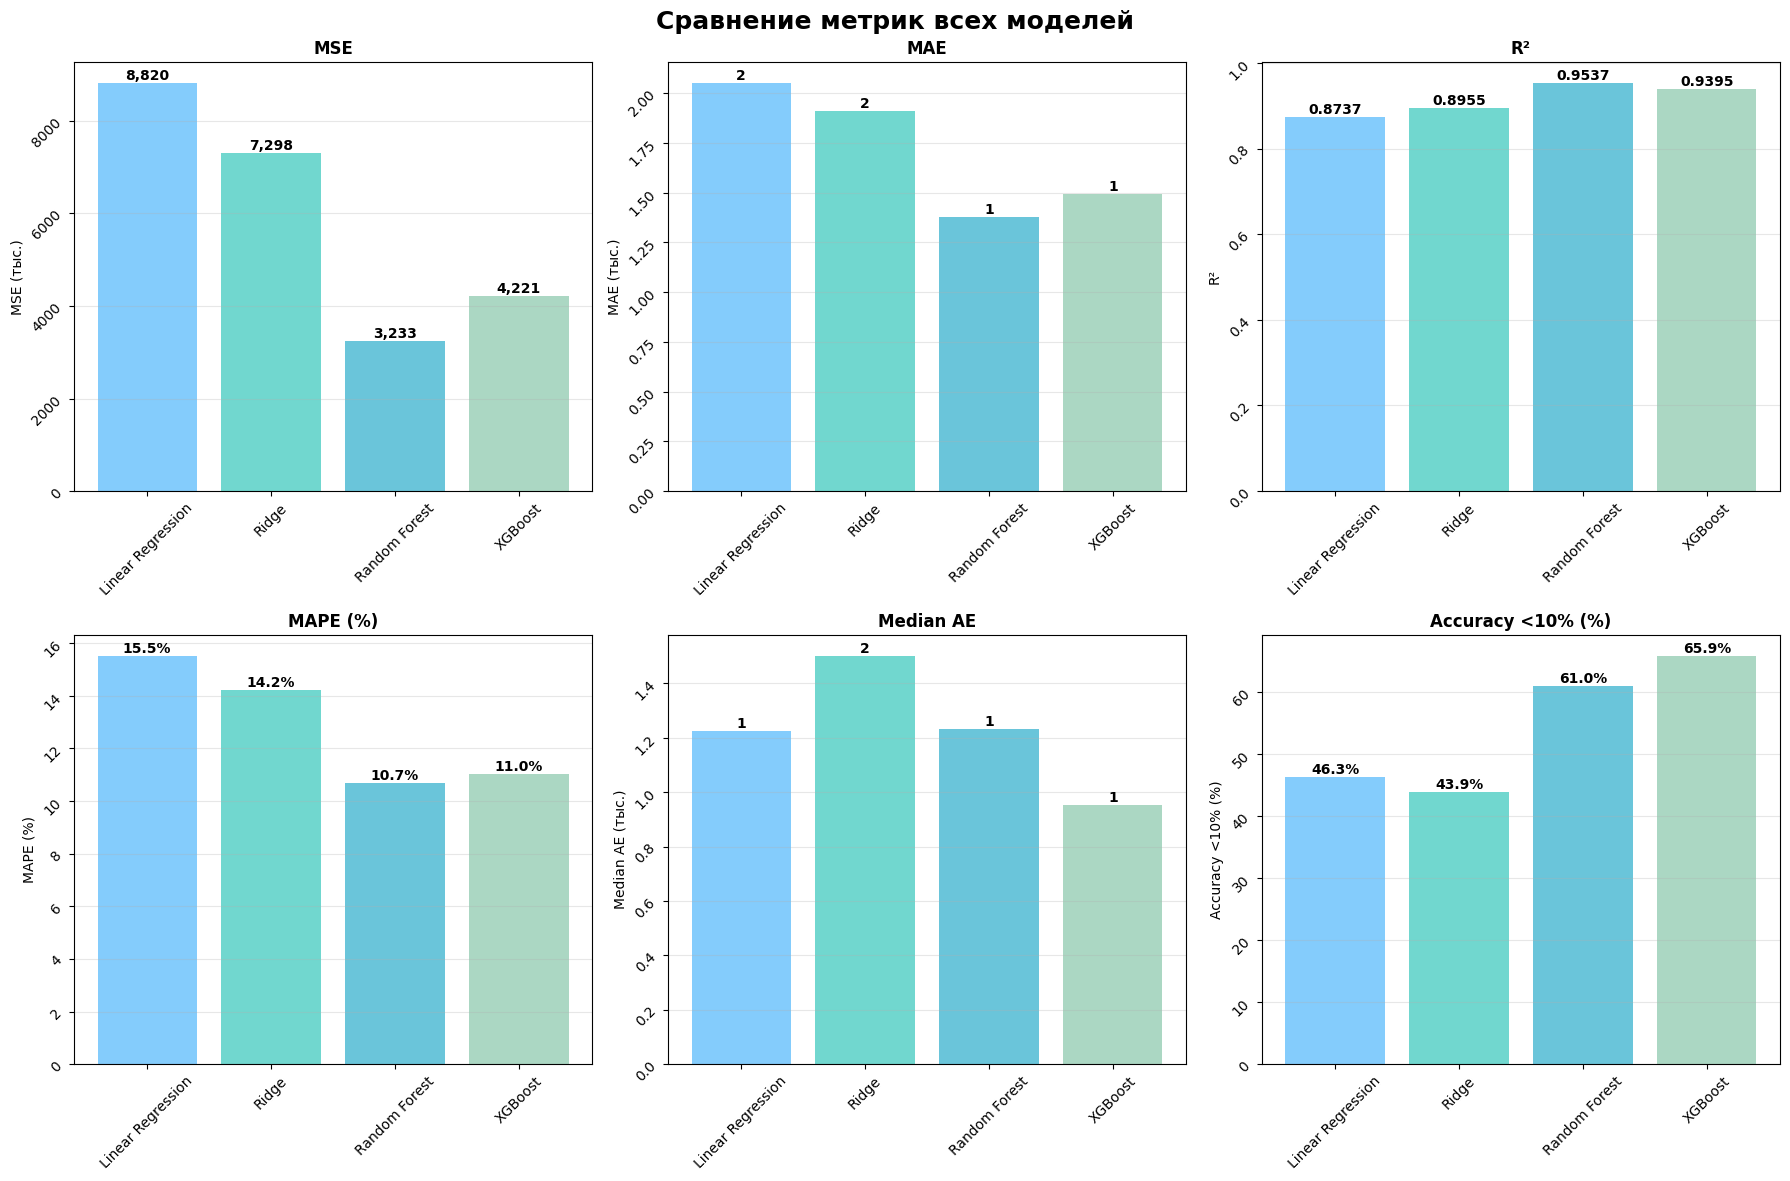

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Сравнение метрик всех моделей', fontsize=18, fontweight='bold')

metrics_to_plot = ['MSE', 'MAE', 'R²', 'MAPE (%)', 'Median AE', 'Accuracy <10% (%)']
colors = ['#65c0fc', '#4ECDC4', '#45B7D1', '#96CEB4']

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i//3, i%3]
    values = results_df[metric]

    if metric in ['MSE', 'MAE', 'Median AE']:
        values_plot = values / 1000
        bars = ax.bar(results_df.index, values_plot, color=colors, alpha=0.8)
        ax.set_ylabel(f'{metric} (тыс.)')
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:,.0f}', ha='center', va='bottom', fontweight='bold')
    elif metric == 'R²':
        bars = ax.bar(results_df.index, values, color=colors, alpha=0.8)
        ax.set_ylabel(metric)
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}', ha='center', va='bottom', fontweight='bold')
    else:
        bars = ax.bar(results_df.index, values, color=colors, alpha=0.8)
        ax.set_ylabel(metric)
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    ax.set_title(metric, fontweight='bold', fontsize=12)
    ax.tick_params(rotation=45)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


🔍 АНАЛИЗ ОСТАТКОВ ДЛЯ ЛУЧШЕЙ МОДЕЛИ (по MAE)
Лучшая модель: Random Forest
MAE: 1,379
R²: 0.9537


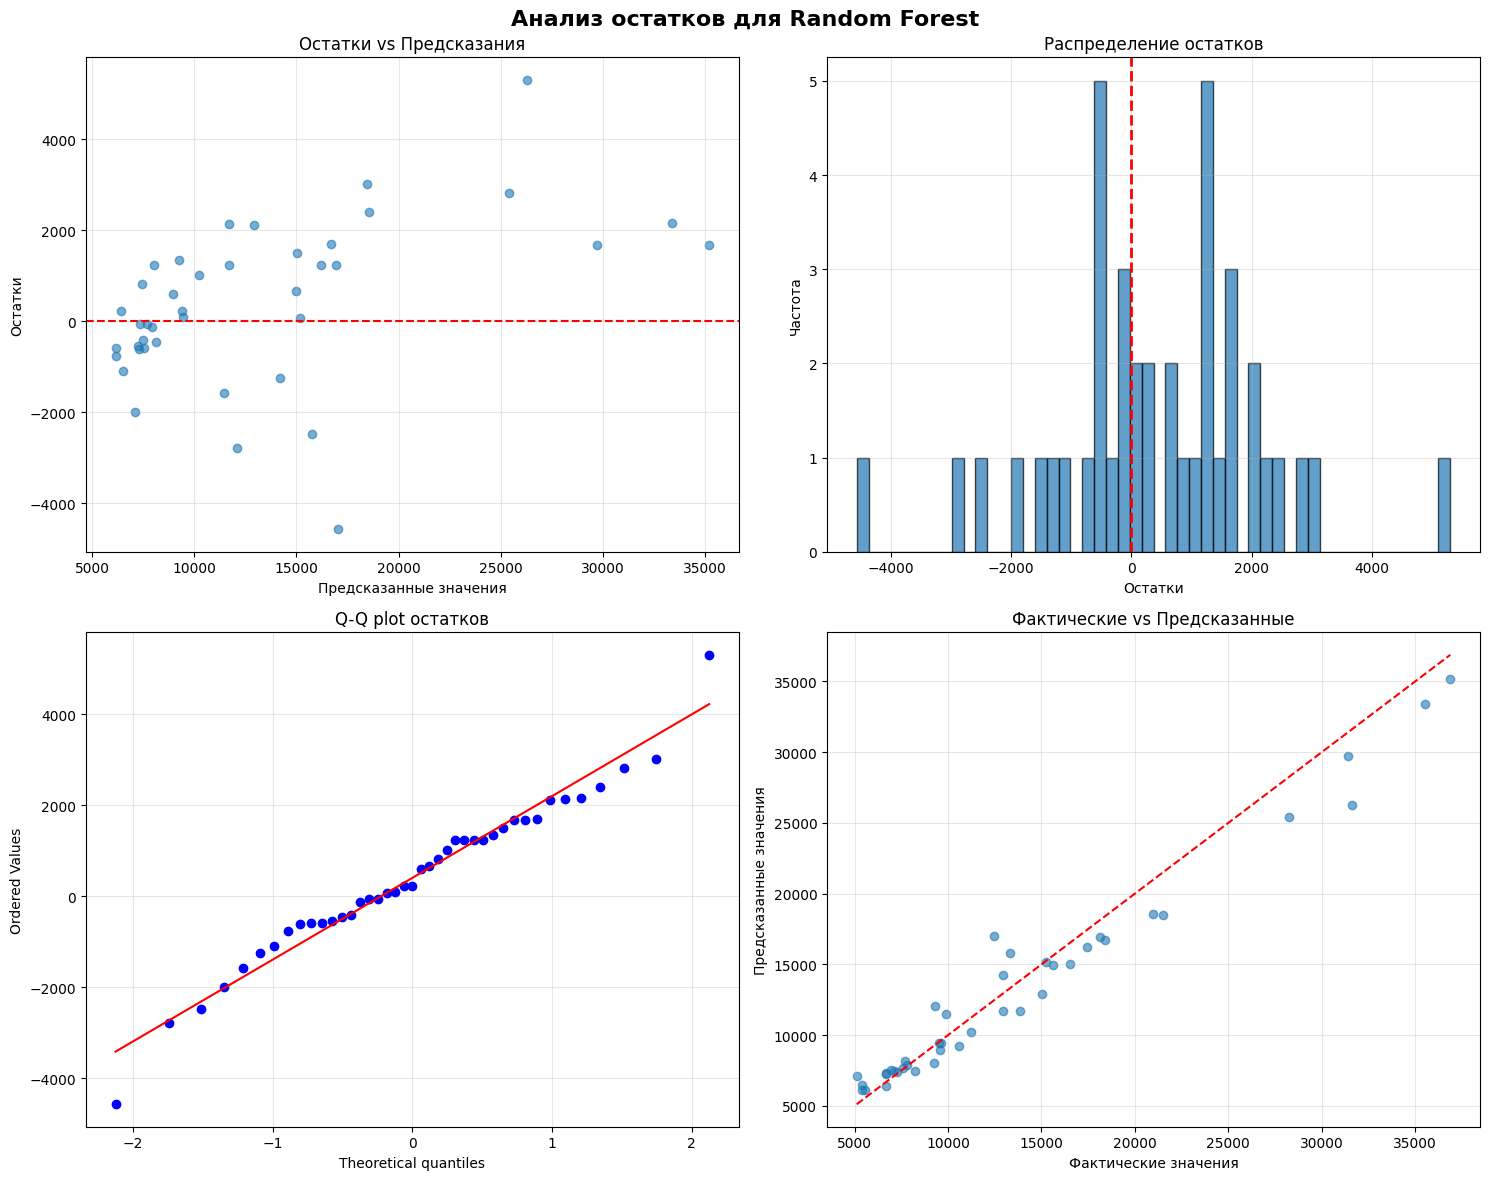

In [15]:
print("\n" + "="*50)
print("🔍 АНАЛИЗ ОСТАТКОВ ДЛЯ ЛУЧШЕЙ МОДЕЛИ (по MAE)")
print("="*50)

best_model_name = results_df['MAE'].idxmin()
best_predictions = predictions[best_model_name]
residuals = y_test - best_predictions

print(f"Лучшая модель: {best_model_name}")
print(f"MAE: {results_df.loc[best_model_name, 'MAE']:,.0f}")
print(f"R²: {results_df.loc[best_model_name, 'R²']:.4f}")

# Графики остатков
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f'Анализ остатков для {best_model_name}', fontsize=16, fontweight='bold')

# 1. Остатки vs Предсказанные значения
axes[0, 0].scatter(best_predictions, residuals, alpha=0.6)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Предсказанные значения')
axes[0, 0].set_ylabel('Остатки')
axes[0, 0].set_title('Остатки vs Предсказания')
axes[0, 0].grid(True, alpha=0.3)

# 2. Гистограмма остатков
axes[0, 1].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Остатки')
axes[0, 1].set_ylabel('Частота')
axes[0, 1].set_title('Распределение остатков')
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q plot остатков
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q plot остатков')
axes[1, 0].grid(True, alpha=0.3)

# 4. Фактические vs Предсказанные значения
axes[1, 1].scatter(y_test, best_predictions, alpha=0.6)
max_val = max(y_test.max(), best_predictions.max())
min_val = min(y_test.min(), best_predictions.min())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'red', linestyle='--')
axes[1, 1].set_xlabel('Фактические значения')
axes[1, 1].set_ylabel('Предсказанные значения')
axes[1, 1].set_title('Фактические vs Предсказанные')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Финальное сравнение моделей
print("\n" + "="*50)
print("🏆 ФИНАЛЬНОЕ СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*50)

print("Лучшая модель по метрикам:")
print(f"• По MAE: {results_df['MAE'].idxmin()} ({results_df['MAE'].min():,.0f})")
print(f"• По R²: {results_df['R²'].idxmax()} ({results_df['R²'].max():.4f})")
print(f"• По MAPE: {results_df['MAPE (%)'].idxmin()} ({results_df['MAPE (%)'].min():.2f}%)")
print(f"• По Accuracy <10%: {results_df['Accuracy <10% (%)'].idxmax()} ({results_df['Accuracy <10% (%)'].max():.2f}%)")


🏆 ФИНАЛЬНОЕ СРАВНЕНИЕ МОДЕЛЕЙ
Лучшая модель по метрикам:
• По MAE: Random Forest (1,379)
• По R²: Random Forest (0.9537)
• По MAPE: Random Forest (10.69%)
• По Accuracy <10%: XGBoost (65.85%)


<h2>5. 💾 Сохранение лучшей модели</h2>

In [14]:
joblib.dump(rf_search, '../models/random_forest_regression_final.pkl')
print("✅ Модель сохранена")

✅ Модель сохранена
